In [1]:
from Data_visualization.Feature_selection import FeatImp
from Data_cleanup.Cleanup import BlueRedSubstraction,Normalisation
from data_collect import detect_outliers,plot_decision_regions
from Training.Training import cross_val_results
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

kfold = KFold(n_splits=8)
data = pd.read_csv('data/lol.csv') 
data_0 = data.drop(['gameId'],axis = 1)
target = data['blueWins']
data_1 = BlueRedSubstraction(data) #spremenjeni podatki
data_2 = pd.concat([data_1,target],axis = 1)
data_3 = data_2.drop(["GoldPerMinDiff","blueWins","CSPerMinDiff"],axis = 1) # ovržem nekatere podobne stolpce,ter target stolpec
train_len = int(data_3.shape[0]*0.8)
train = data_3[:train_len]
test = data_3[train_len:]

target_train = target[:train_len]
target_test = target[train_len:].reset_index()
norm = Normalisation(MM = True)
train_sc, train_mm = norm.transform(X = train)
test_sc,test_mm = norm.transform(X=test)
target_test = target_test["blueWins"]
target_test = pd.Series(target_test)

In [10]:
'''Fine tuning Random forest Classifier'''
RFC = RandomForestClassifier()
kfold = KFold(n_splits=10)

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[10,100,1000,50],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(train_sc,target_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed: 29.7min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed: 54.9min finished


0.7295944886299989

In [16]:
print(gsRFC.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 1000}


In [2]:
LR = LogisticRegression()
lr_param_grid = {"penalty":['l1', 'l2'],
                 "C":[0.1,0.2,0.5,1.0,1.5,2.0,2.7],
                 "solver":['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
gsLR = GridSearchCV(LR,param_grid = lr_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsLR.fit(train_sc,target_train)

LR_best = gsLR.best_estimator_

# Best score
gsLR.best_score_

Fitting 8 folds for each of 70 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   21.2s finished


0.735292865961959

In [39]:
LR_best = LR.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}


In [40]:
SC = SVC()

sc_param_grid = {"C":[0.1,0.5,0.7,1.0,2.0,2.5,2.7,3.0],
                 "kernel":['linear','poly','rbf','sigmoid'],
                 "degree":[2,3,4],
                 "gamma": ['scale','auto']
                }
gsSC = GridSearchCV(SC,param_grid = sc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
gsSC.fit(train_sc,target_train)

SC_best = gsSC.best_estimator_

# Best score
gsSC.best_score_

Fitting 8 folds for each of 192 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed: 32.0min finished


0.732003520462367

In [70]:
SVMC_best = gsSC.best_estimator_
LR_best= gsLR.best_estimator_
RFC_best = RandomForestClassifier(n_estimators=1000,criterion ='gini',bootstrap=False,max_features=1,min_samples_leaf=10,min_samples_split=2)

SVC(C=2.0, degree=2, kernel='linear')


In [104]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
('svc', SVMC_best),('LR',LR_best)], voting='hard', n_jobs=-1)

votingC = votingC.fit(train_sc, target_train)

In [133]:
test_Won = pd.Series(votingC.predict(test_sc), name="BlueWon")

results = pd.concat([target_test,test_Won],axis=1)
tp_tn = results[results["blueWins"]==results["BlueWon"]]

acc = len(tp_tn)/(results.shape[0])

In [134]:
results.head(20)
print(acc)

0.7257085020242915


In [113]:
acc

0.7257085020242915

In [132]:
test_LR = pd.Series(LR_best.predict(test_sc), name="BlueWon")

resultsLR = pd.concat([target_test,test_LR],axis=1)
tp_tnLR = results[results["blueWins"]==results["BlueWon"]]
falseLR = results[results["blueWins"]!=results["BlueWon"]]
accLR = len(tp_tnLR)/(results.shape[0])
print(accLR)
print(1-accLR)

0.7257085020242915
0.2742914979757085


In [131]:
test_SC = pd.Series(SVMC_best.predict(test_sc), name="BlueWon")

resultsSC = pd.concat([target_test,test_LR],axis=1)
tp_tnSC = results[results["blueWins"]==results["BlueWon"]]
falseSC = results[results["blueWins"]!=results["BlueWon"]]
accSC = len(tp_tnSC)/(results.shape[0])
print(accSC)
print(1-accSC)

0.7257085020242915
0.2742914979757085


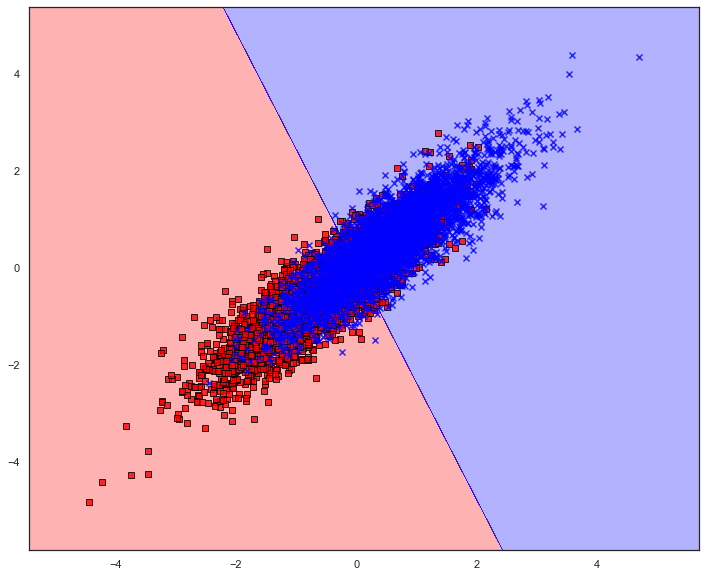

In [49]:
train_scG =train_sc["TotalGoldDiff"].to_numpy().reshape(train_sc.shape[0],1)
train_scE = train_sc["TotalExperienceDiff"].to_numpy().reshape(train_sc.shape[0],1)
X = np.hstack([train_scG, train_scE ])
#print(len(X[target_train==1,0]),len(X[target_train==1,1]))
LR2 = LogisticRegression()
LR2.fit(X,target_train)
plt.figure(figsize=(12,10))
plot_decision_regions(X,y=target_train,classifier=LR2)

In [ ]:
'''Ugotovim, da je najprimernejši model kar Logistična Regresija, kar je logično kajti med Featuri obstaja velika medsebojna linearna
korelacija. Najpomembnejši feature-i so TotalGoldDiff, TotalExperienceDiff ter TotalGoldDiff. Med sabo so ti featuri močno povezani,
ker imajo vsi vpliv drug na drugega. Naprimer če dobiš Kill se ti poveča Experience, prav tako pa dobiš več Gold-a. Ti trije featuri
potem diktirajo ostale. Več Golda imaš, bolj se lahko opremiš ter dobiš nadaljne bitke z nasprotniki, prav tako lažje nadziraš mapo ter 
ubijaš Legendarne pošasti. Na zgornji sliki vidimo, da pride vseeno do velikega prekrivanja, zaradi česar lahko veliko tekem le
ugibamo. Vendar pa lahko rečemo, da ima priigranje prednosti v prvih 10 minutah izjemno pomembno vlogo, kajti z našim modelom dosežemo 
skoraj 75% natančnost napovedi. 